# Power traces analysis

This is just a test before applying on the chips. It uses python rather than C.

In [160]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from keras.preprocessing.sequence import TimeseriesGenerator
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import pickle

In [12]:
mpl.rcParams['agg.path.chunksize'] = 10000

## 1. Data Preprocessing

**Read data from csv file**: get data.

In [2]:
file_path = "../dataset/grafana_data_export.csv"

data = pd.read_csv(file_path, \
                   error_bad_lines=False, warn_bad_lines=False, \
                   sep=';', thousands=',', \
                   dtype={'Series': 'object', 'Value': 'float'}, \
                   parse_dates=['Time'])

display(data.head())
print("Data shape: {0}".format(data.shape))

,Series,Time,Value
0,Black and white printer,2018-10-27 16:44:25,3.31
1,Black and white printer,2018-10-27 16:44:25,3.31
2,Black and white printer,2018-10-27 16:44:26,4.29
3,Black and white printer,2018-10-27 16:44:26,4.29
4,Black and white printer,2018-10-27 16:44:27,3.77


Data shape: (1940080, 3)


In [3]:
data.dtypes

Series            object
Time      datetime64[ns]
Value            float64
dtype: object

**Label Encoding**

In [4]:
encoder = LabelEncoder()
data['Series'] = encoder.fit_transform(data['Series'])

display(data.head(10))

,Series,Time,Value
0,0,2018-10-27 16:44:25,3.31
1,0,2018-10-27 16:44:25,3.31
2,0,2018-10-27 16:44:26,4.29
3,0,2018-10-27 16:44:26,4.29
4,0,2018-10-27 16:44:27,3.77
5,0,2018-10-27 16:44:27,3.77
6,0,2018-10-27 16:44:28,4.03
7,0,2018-10-27 16:44:28,4.03
8,0,2018-10-27 16:44:30,2.71
9,0,2018-10-27 16:44:30,2.71


**Data Visualization**

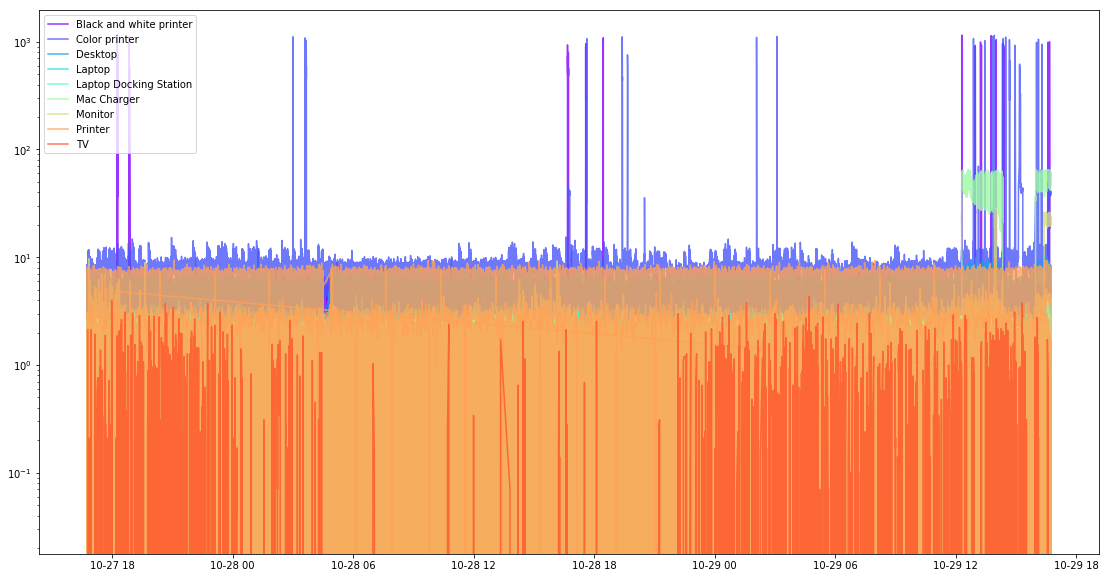

In [15]:
color = iter(plt.cm.rainbow(np.linspace(0,1,10)))

plt.figure(figsize=(19,10))

for cur_class in range(len(encoder.classes_)):
    c = next(color)
    indices = np.where(data['Series'] == cur_class)
    time = np.array(data.loc[indices[0], ['Time']])
    value = np.array(data.loc[indices[0], ['Value']])
    
    plt.plot(time, value, c=c, label=encoder.classes_[cur_class], alpha=0.8)

plt.yscale('log')
plt.legend()
plt.show()

**Filter and Resample**: Filter data with repeated time steps and NaN.

In [70]:
filtered_data = []

print("Size of samples from different classes:\n")
for cur_class in range(len(encoder.classes_)):
    indices = np.where(data['Series'] == cur_class)
    filtered_data.append(data.loc[indices[0], ['Time', 'Value']])
    
    print(" {0}: {1}".format(encoder.classes_[cur_class], filtered_data[cur_class].shape))

Size of samples from different classes:

 Black and white printer: (211917, 2)
 Color printer: (67373, 2)
 Desktop: (162914, 2)
 Laptop: (169641, 2)
 Laptop Docking Station: (207065, 2)
 Mac Charger: (162684, 2)
 Monitor: (544604, 2)
 Printer: (411291, 2)
 TV: (2591, 2)


In [71]:
for cur_class in range(len(encoder.classes_)):
    filtered_data[cur_class] = filtered_data[cur_class].resample('1S', on='Time').mean()
    filtered_data[cur_class].interpolate(inplace=True)

**Partitioning**: partition the whole power traces into small traces with a duration of *k* seconds. The label of these small traces is the corresponding value in Series.

In [87]:
X, y = [], []

for cur_class in range(len(encoder.classes_)):
    print("Partitioning class {0}...".format(cur_class))
    
    value = np.array(filtered_data[cur_class]['Value'])
    series = np.array(np.full(value.shape, cur_class))
    
    generator = TimeseriesGenerator(value, series,
                       length=60, sampling_rate=1, batch_size=1)
    
    for sample in generator:
        X.append(sample[0])
        y.append(sample[1])

X, y = np.array(X), np.array(y)

Partitioning class 0...
Partitioning class 1...
Partitioning class 2...
Partitioning class 3...
Partitioning class 4...
Partitioning class 5...
Partitioning class 6...
Partitioning class 7...
Partitioning class 8...


In [ ]:
X = np.reshape(X, (X.shape[0], X.shape[2]))

(**\*Save data in file / Load data from file**: Reduce unnecessary computation.)

In [122]:
dataFile = "X_y_data"

In [123]:
with open(dataFile, 'wb') as outfile:
    pickle.dump([X, y], outfile)

In [124]:
with open(dataFile, 'rb') as infile:
    X, y = pickle.load(infile)

**FFT**

In [125]:
fft_X_real, fft_X_imag = np.empty(X.shape), np.empty(X.shape)
 
for i in range(len(X)):
    sp = np.fft.fft(X[i, :])
    fft_X_real[i, :] = sp.real
    fft_X_imag[i, :] = sp.imag

**Generating training/testing data set**: train test split

In [126]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=76)
print("{0} train + {1} validation + {2} test".format(len(X_train), len(X_val), len(X_test)))

994633 train + 248659 validation + 310823 test


**Data Visualization**: Visualize different types of signals.

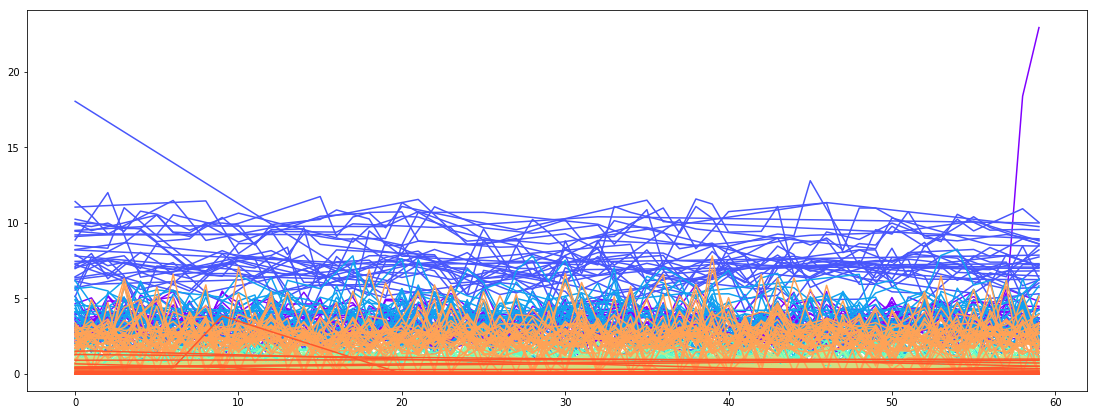

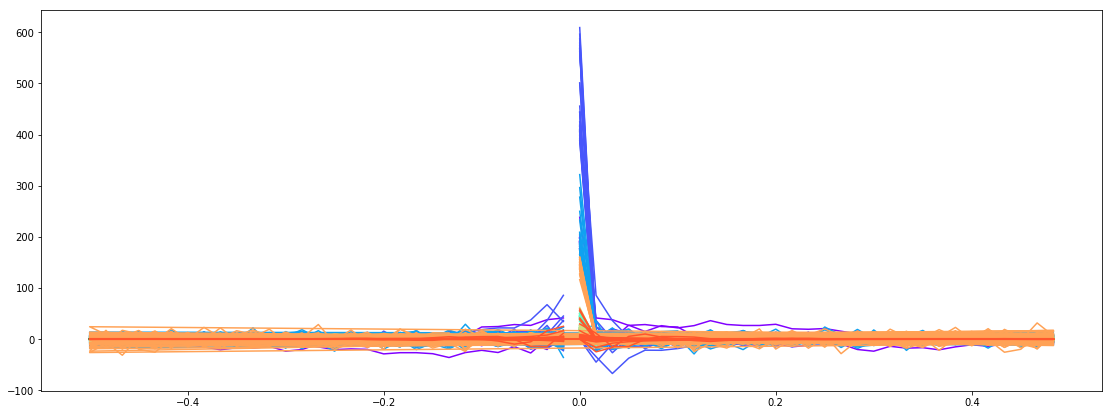

In [132]:
color = iter(plt.cm.rainbow(np.linspace(0,1,10)))

fig1, ax1 = plt.subplots(figsize=(19, 7))
fig2, ax2 = plt.subplots(figsize=(19,7))

t = np.arange(60)
freq = np.fft.fftfreq(t.shape[-1])
for k in range(9):
    c = next(color)
    for sample in X_train[np.where(y_train == k)[0][:30]]:
        ax1.plot(np.arange(0, 60, 1), sample, c=c)
        
        sp = np.fft.fft(sample)
        freq = np.fft.fftfreq(t.shape[-1])
        ax2.plot(freq, sp.real, freq, sp.imag, c=c)

plt.show()

## 2. Try different classification models

Followed the document [Classifier comparison](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) and [Confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) on scikit learn site.

In [133]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [138]:
names = ["Linear SVM", 
         "RBF SVM",
         "Random Forest", 
         "Neural Net",
         "Voting"]

classifiers = [
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    VotingClassifier(estimators=[
        ('knn', KNeighborsClassifier(3)), 
        ('rf', RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)), 
        ('nn', MLPClassifier(alpha=1))], voting='hard')
]

In [139]:
train_size = 10000
test_size = 1000

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear SVM:
accuracy score: 0.549
Confusion matrix, without normalization
[[ 60   1  33   0   0   0   0   2   0]
 [  0 113   0   0   0   1   0   0   0]
 [ 71   1  43   0   0   0   0   6   0]
 [  0   0   0  64   0   7  27   0   0]
 [  0   0   0   0 123   0   1   0   0]
 [  0  10   0  71   0   0  23   0   1]
 [  0   0   0  29   4   4  81   0   0]
 [ 27   0  26   0   0   2   0  65   0]
 [  0   0   0  75  18   0   9   2   0]]


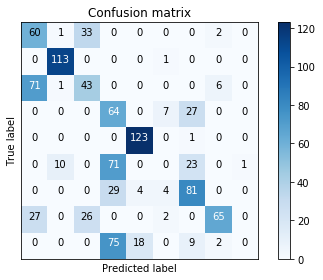

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RBF SVM:
accuracy score: 0.218
Confusion matrix, without normalization
[[  0   0   0   0  96   0   0   0   0]
 [  0   0   0   0 114   0   0   0   0]
 [  0   0   1   0 120   0   0   0   0]
 [  0   0   0   0  95   0   0   0   3]
 [  0   0   0   0 124   0   0   0   0]
 [  0   0   0   0 105   0   0   0   0]
 [  0   0   0   0 118   0   0   0   0]
 [  0   0   0   0 120   0   0   0   0]
 [  0   0   0   0  11   0   0   0  93]]


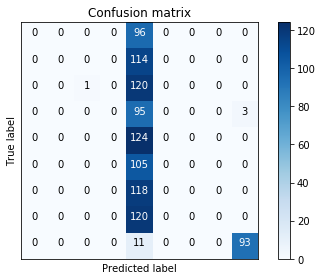

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Random Forest:
accuracy score: 0.665
Confusion matrix, without normalization
[[ 86   0   5   0   0   0   0   5   0]
 [  0 114   0   0   0   0   0   0   0]
 [ 64   3  23   0   0   0   0  31   0]
 [  0   0   0  81   2   3   6   0   6]
 [  0   0   0   0  99   2  23   0   0]
 [  0   0   0  78   2  15   7   0   3]
 [  0   0   0   1   9   3 105   0   0]
 [ 12   0   7   0   0   0   0 101   0]
 [  0   0   0   6  10   0  44   3  41]]


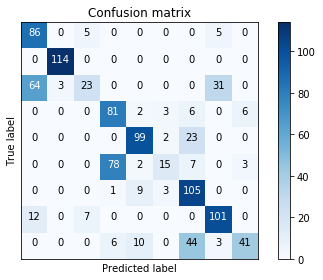

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Neural Net:
accuracy score: 0.757
Confusion matrix, without normalization
[[ 85   1   9   0   0   0   0   1   0]
 [  2 111   0   1   0   0   0   0   0]
 [ 56   2  49   0   0   0   0  14   0]
 [  0   0   0  41   1  44   8   0   4]
 [  0   0   0   0 122   0   2   0   0]
 [  0   3   0  36   0  50  15   0   1]
 [  0   0   0   0   4   8 106   0   0]
 [  8   0  10   0   0   0   0 102   0]
 [  0   0   0   0   1   0  12   0  91]]


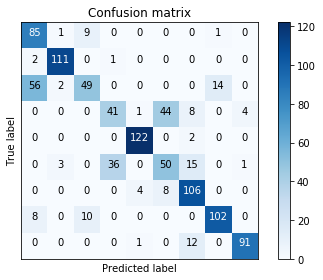

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Voting:
accuracy score: 0.732
Confusion matrix, without normalization
[[ 93   1   1   0   0   0   0   1   0]
 [  2 112   0   0   0   0   0   0   0]
 [ 86   2  25   0   0   0   0   8   0]
 [  0   0   0  81   0   5   6   0   6]
 [  0   0   0   2 121   0   1   0   0]
 [  0   0   0  76   2  14  11   0   2]
 [  0   0   0   3  10   7  98   0   0]
 [ 13   0   8   0   0   0   0  99   0]
 [  0   0   0   1   1   0  13   0  89]]


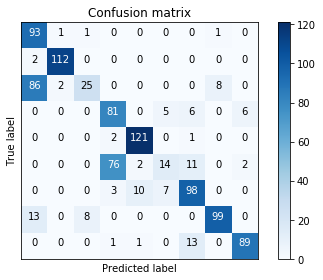

In [140]:
for name, clf in zip(names, classifiers):
    clf.fit(X_train[:train_size, :], y_train[:train_size])
    y_pred = clf.predict(X_test[:test_size, :])
    
    score = accuracy_score(y_test[:test_size], y_pred)
    
    print("{0}:".format(name))
    print("accuracy score: {0}".format(score))
    
    cnf_matrix = confusion_matrix(y_test[:test_size], y_pred)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[])
    plt.show()

## 3. Using Neural Network

In [178]:
import keras
from keras.models import Sequential
from keras.models import Input, Model
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, GRU
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import EarlyStopping
from tcn import TCN

**Get new nn_y_train and nn_y_test**: To meet the output layer requirement of DNN.

In [164]:
hot_encoder = OneHotEncoder(categories='auto')

hot_encoder.fit(y_train)
y_train = hot_encoder.transform(y_train).toarray()
y_test = hot_encoder.transform(y_test).toarray()

**Training and Testing**

In [191]:
train_size = 1000000
val_size = 1000
test_size = 100

X_train = np.reshape(X_train, (X_train.shape[0],
                              X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0],
                              X_test.shape[1]))

**DNN**

In [192]:
model = Sequential()
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model.add(Dense(128, activation='relu', input_dim=60))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(9, activation='softmax'))

adam = Adam()
model.compile(loss='mse',
              optimizer=adam,
              metrics=['accuracy'])

history = model.fit(X_train[:train_size], y_train[:train_size], 
                    epochs=50, batch_size=200, validation_split=0.2,
                    callbacks=[early_stopping])

Train on 795706 samples, validate on 198927 samples
Epoch 1/50
795706/795706 [==============================] - 15s 19us/step - loss: 0.0308 - acc: 0.7975 - val_loss: 0.0244 - val_acc: 0.8436
Epoch 2/50
795706/795706 [==============================] - 13s 16us/step - loss: 0.0244 - acc: 0.8434 - val_loss: 0.0248 - val_acc: 0.8413
Epoch 3/50
795706/795706 [==============================] - 13s 16us/step - loss: 0.0234 - acc: 0.8502 - val_loss: 0.0232 - val_acc: 0.8506
Epoch 4/50
795706/795706 [==============================] - 13s 16us/step - loss: 0.0226 - acc: 0.8551 - val_loss: 0.0221 - val_acc: 0.8588
Epoch 5/50
795706/795706 [==============================] - 13s 17us/step - loss: 0.0221 - acc: 0.8585 - val_loss: 0.0217 - val_acc: 0.8604
Epoch 6/50
795706/795706 [==============================] - 13s 16us/step - loss: 0.0218 - acc: 0.8606 - val_loss: 0.0228 - val_acc: 0.8537
Epoch 7/50
795706/795706 [==============================] - 13s 17us/step - loss: 0.0215 - acc: 0.8622 - val

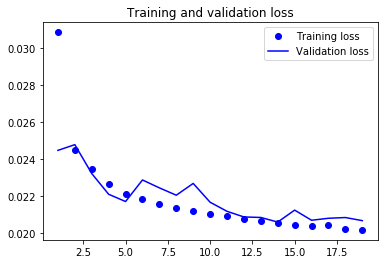

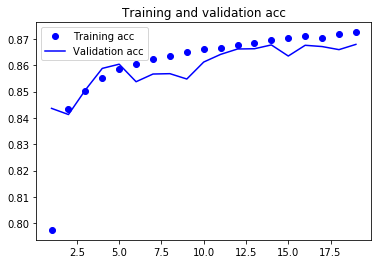

In [194]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.show()

**TCN**

In [ ]:
batch_size, timesteps, input_dim = None, 30, 1

i = Input(batch_shape=(batch_size, timesteps, input_dim))

o = TCN(return_sequences=False,
        use_skip_connections=True,
        nb_stacks=2,
        dilations=[2 ** i for i in range(9)])(i)  # The TCN layers are here.
o = Dense(100, activation='relu')(o)
o = Dense(9, activation='softmax')(o)

m = Model(inputs=[i], outputs=[o])
m.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

history = m.fit(X_train[:train_size], nn_y_train[:train_size], epochs=10, validation_split=0.2)

In [ ]:
score = m.evaluate(X_test[:test_size], nn_y_test[:test_size])
score

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
################## TEST SECTION ###################
